<a href="https://colab.research.google.com/github/moodlep/mlc-proj-soccer/blob/main/Colabs/sb3_soccer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

Copied from dm_control introduction tutorial

### Installing `dm_control` on Colab

This notebook provides an overview tutorial of DeepMind's `dm_control` package, hosted at the [deepmind/dm_control](https://github.com/deepmind/dm_control) repository on GitHub.

It is adjunct to this [tech report](http://arxiv.org/abs/2006.12983).

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".

In [1]:
# Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

mujoco_dir = "$HOME/.mujoco"

print('Installing OpenGL dependencies...')
!apt-get update -qq
!apt-get install -qq -y --no-install-recommends libglew2.0 > /dev/null

print('Downloading MuJoCo...')
MUJOCO_VERSION = 210
MUJOCO_ARCHIVE = (
    f'mujoco{MUJOCO_VERSION}-{distutils.util.get_platform()}.tar.gz')
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}"
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}.sha256"
check_result = !shasum -c "{MUJOCO_ARCHIVE}.sha256"
if _exit_code:
  raise RuntimeError(
      'Downloaded MuJoCo archive is corrupted (checksum mismatch)')

print('Unpacking MuJoCo...')
MUJOCO_DIR = '$HOME/.mujoco'
!mkdir -p "{MUJOCO_DIR}"
!tar -zxf {MUJOCO_ARCHIVE} -C "{MUJOCO_DIR}"

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Installing dm_control...')
!pip install -q dm_control

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, env, pixels

Installing OpenGL dependencies...
Unpacking MuJoCo...
env: MUJOCO_GL=egl
Installing dm_control...
     |████████████████████████████████| 38.6 MB 1.6 MB/s 
     |████████████████████████████████| 205 kB 35.1 MB/s 
     |████████████████████████████████| 4.9 MB 34.9 MB/s 
Checking that the dm_control installation succeeded...


Exception ignored in: <function _create_finalizer.<locals>.callback at 0x7fb01842fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 261, in callback
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 802, in finalize_mjr_context
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
  File "/usr/local/lib/python3.7/dist-packages/dm_control/_render/base.py", line 114, in make_current
RuntimeError: Cannot make context <dm_control._render.pyopengl.egl_renderer.EGLContext object at 0x7fb01840ef50> current on thread <Thread(_colab_inspector_thread, started daemon 140394442774272)>: this context is already current on another thread <_MainThread(MainThread, started 140395094841216)>.


## Installing SB3 - obsolete

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  xserver-common
Recommended packages:
  xfonts-base
The following NEW packages will be installed:
  xvfb
The following packages will be upgraded:
  xserver-common
1 upgraded, 1 newly installed, 0 to remove and 84 not upgraded.
Need to get 811 kB of archives.
After this operation, 2,272 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.10 [26.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 811 kB in 1s (743 kB/s)
(Reading database ... 155227 files and directories currently installed.)
Preparing to unpack .../xserver-comm

In [ ]:
!pip install stable-baselines3[extra]

     |████████████████████████████████| 174 kB 5.1 MB/s 


# Imports

dm_control imports

In [2]:
# All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [3]:
# Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

## Other imports

In [4]:
import gym
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Testing installations

## Paper links: 

https://arxiv.org/pdf/2006.12983.pdf

https://arxiv.org/pdf/1902.07151.pdf



## SB3

In [ ]:
from stable_baselines3 import PPO

env = gym.make("CartPole-v1")

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    # env.render()
    if done:
      obs = env.reset()

env.close()

In [ ]:
# Set up fake display; otherwise rendering will fail
# import os
# os.system("Xvfb :1 -screen 0 1024x768x24 &")
# os.environ['DISPLAY'] = ':1'

Errors with display (rendering)

https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym


https://davidrpugh.github.io/stochastic-expatriate-descent/openai/binder/google-colab/2020/04/16/remote-rendering-gym-envs.html



## Testing dm_control (taken from tutorial)

### Multi-Agent Soccer

Building on Composer and Locomotion libraries, the Multi-agent soccer environments, introduced in [this paper](https://arxiv.org/abs/1902.07151), follow a consistent task structure of Walkers, Arena, and Task where instead of a single walker, we inject multiple walkers that can interact with each other physically in the same scene. The code snippet below shows how to instantiate a 2-vs-2 Multi-agent Soccer environment with the simple, 5 degree-of-freedom `BoxHead` walker type.

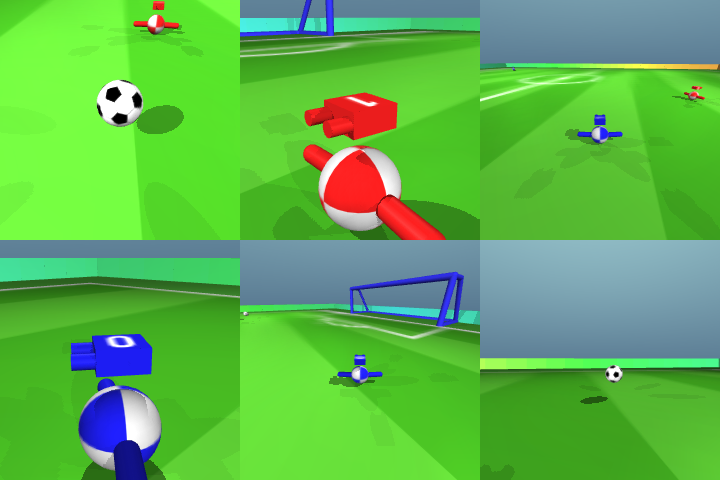

In [5]:
#@title 2-v-2 `Boxhead` soccer

random_state = np.random.RandomState(42)
env = soccer.load(
    team_size=2,
    time_limit=45.,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.BOXHEAD,
    terminate_on_goal=True
)
env.reset()
pixels = []
# Select a random subset of 6 cameras (soccer envs have lots of cameras)
cameras = random_state.choice(env.physics.model.ncam, 6, replace=False)
for camera_id in cameras:
  pixels.append(env.physics.render(camera_id=camera_id, width=240))
image = np.vstack((np.hstack(pixels[:3]), np.hstack(pixels[3:])))
PIL.Image.fromarray(image)

#### Managing Observations

In [6]:
state = env.reset()
state

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=[OrderedDict([('body_height', array([1.])), ('end_effectors_pos', array([[0., 0., 0.]])), ('joints_pos', array([[0.]])), ('joints_vel', array([[0.]])), ('prev_action', array([[0., 0., 0.]])), ('sensors_accelerometer', array([[-1.44971364e-55,  2.51767267e-42,  0.00000000e+00]])), ('sensors_gyro', array([[-0.,  0.,  0.]])), ('sensors_velocimeter', array([[-0.,  0.,  0.]])), ('world_zaxis', array([[-0.,  0.,  1.]])), ('ball_ego_angular_velocity', array([[0., 0., 0.]])), ('ball_ego_position', array([[-4.59061861, 11.14147135, -0.15      ]])), ('ball_ego_linear_velocity', array([[0., 0., 0.]])), ('teammate_0_ego_linear_velocity', array([[0., 0., 0.]])), ('teammate_0_ego_position', array([[-28.45943793, -11.24506866,   0.        ]])), ('teammate_0_ego_orientation', array([[-0.99806643,  0.06215631,  0.        , -0.06215631, -0.99806643,
         0.        ,  0.        ,  0.        ,  1.        ]])), ('teammate_0

In [7]:
# https://github.com/hcch0912/gym_wrapper_dm_soccer/blob/master/soccer_wrapper.py

def parse_obs(observation, n_agents):
        obs = [[]] 
        for i in range(n_agents):
            for _, v in observation[i].items():
                v = v.flatten()
                for j in range(len(v)):
                    obs[i].append(float(v[j]))
                    
        return obs

In [8]:
observation = state.observation
n_agents = 4
obs = [[]] * n_agents
obs, observation[0]

([[], [], [], []],
 OrderedDict([('body_height', array([1.])),
              ('end_effectors_pos', array([[0., 0., 0.]])),
              ('joints_pos', array([[0.]])),
              ('joints_vel', array([[0.]])),
              ('prev_action', array([[0., 0., 0.]])),
              ('sensors_accelerometer',
               array([[-1.44971364e-55,  2.51767267e-42,  0.00000000e+00]])),
              ('sensors_gyro', array([[-0.,  0.,  0.]])),
              ('sensors_velocimeter', array([[-0.,  0.,  0.]])),
              ('world_zaxis', array([[-0.,  0.,  1.]])),
              ('ball_ego_angular_velocity', array([[0., 0., 0.]])),
              ('ball_ego_position',
               array([[-4.59061861, 11.14147135, -0.15      ]])),
              ('ball_ego_linear_velocity', array([[0., 0., 0.]])),
              ('teammate_0_ego_linear_velocity', array([[0., 0., 0.]])),
              ('teammate_0_ego_position',
               array([[-28.45943793, -11.24506866,   0.        ]])),
              

In [ ]:
for i in range(n_agents):
  print(i)
  for _, v in observation[i].items():
      v = v.flatten()
      print(len(v))
      for j in range(len(v)):
          obs[i].append(float(v[j]))


In [ ]:
len(obs[0])

158.66666666666666

In [ ]:
for i in env.observation_spec():
  print(i)

OrderedDict([('body_height', Array(shape=(1,), dtype=dtype('float64'), name='body_height')), ('end_effectors_pos', Array(shape=(1, 3), dtype=dtype('float64'), name='end_effectors_pos')), ('joints_pos', Array(shape=(1, 1), dtype=dtype('float64'), name='joints_pos')), ('joints_vel', Array(shape=(1, 1), dtype=dtype('float64'), name='joints_vel')), ('prev_action', Array(shape=(1, 3), dtype=dtype('float64'), name='prev_action')), ('sensors_accelerometer', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_accelerometer')), ('sensors_gyro', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_gyro')), ('sensors_velocimeter', Array(shape=(1, 3), dtype=dtype('float64'), name='sensors_velocimeter')), ('world_zaxis', Array(shape=(1, 3), dtype=dtype('float64'), name='world_zaxis')), ('ball_ego_angular_velocity', Array(shape=(1, 3), dtype=dtype('float64'), name='ball_ego_angular_velocity')), ('ball_ego_position', Array(shape=(1, 3), dtype=dtype('float64'), name='ball_ego_position')), (

In [ ]:
env.action_spec()

[BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.]),
 BoundedArray(shape=(3,), dtype=dtype('float64'), name='roll\tsteer\tkick', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])]

# Wrap dm_soccer into a gym env

## dm_soccer gym wrapper - status: Active

https://github.com/hcch0912/gym_wrapper_dm_soccer



In [9]:
import numpy as np
from dm_control.locomotion import soccer as dm_soccer
from gym.spaces import Box
import sys

class DMSoccer():
    def __init__(self, batch_size=None, **kwargs):
        # super().__init__(batch_size, **kwargs)
        self.base_env = dm_soccer.load(kwargs["team_size"], kwargs["time_limit"])
        act_spec = self.base_env.action_spec()
        self.n_agents = len(act_spec)
        self.observation_space = Box(low=-10000, high=10000, shape=(self.n_agents,476 ))
        # self.observation_space = Box(low=-10000, high=10000, shape=(self.n_agents,154 ))
        self.action_space = Box(low=-1, high=1, shape=(self.n_agents, 3)) 

    def parse_obs(self, observation):
        obs = [[]] * self.n_agents
        for i in range(self.n_agents):
            for _, v in observation[i].items():
                v = v.flatten()
                for j in range(len(v)):
                    obs[i].append(float(v[j]))
        return np.array(obs)

    def get_reward(self, observation, origin_reward):
        """if goal, return the original reward, else, return the shaped dense reward
        """
        rewards = [0.0] * self.n_agents
        for i in range(self.n_agents):
            if not origin_reward or origin_reward[i] == 0.0:
                home_score = observation[i]["stats_home_score"]
                away_score = observation[i]["stats_away_score"]
                velocity_to_ball = observation[i]["stats_vel_to_ball"]
                velocity_to_goal = observation[i]["stats_vel_ball_to_goal"]
                rewards[i] = (
                    home_score
                    - away_score
                    + 0.001 * velocity_to_ball
                    + 0.002 * velocity_to_goal
                )
            else:
                rewards[i] = origin_reward[i]
        return rewards

    def step(self, actions):
        try:
            timestep = self.base_env.step(actions)
        except:
            obs = self.parse_obs(self.base_env.reset().observation)
            return obs, [0] * self.n_agents, True, None
        # concatenate all the values in the observation dict as the observation for each agent
        obs = self.parse_obs(timestep.observation)
        done = timestep.discount == 0

        # reward = self.get_reward(timestep.observation, timestep.reward)
        reward = timestep.reward
        return obs, reward, done, None

    def reset(self, **kwargs):
        timestep = self.base_env.reset()
        obs = self.parse_obs(timestep.observation)
        return obs

    def render(self, **kwargs):
        self.base_env.render()


In [10]:
dm_env = DMSoccer(team_size=2, time_limit=45,)
obs = dm_env.reset() 
done = False

In [11]:
dm_env.observation_space

Box(-10000.0, 10000.0, (4, 476), float32)

In [ ]:
# while not done:
for i in range(10):
  actions = [] 
  for action_spec in range(len(obs)):
    action = np.random.uniform(-1, 1, size=(3,))
    actions.append(action)

  obs, reward, done, _ = dm_env.step(actions)
  print(reward, action, obs)

In [13]:
class DMSoccerEnv(gym.Env):
    def __init__(self):
        self.env = DMSoccer(team_size=2, time_limit=45.,)
        self.n_agents = self.env.n_agents
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        return next_state, reward, done, info

    def reset(self):
      return self.env.reset()

    def render(self):
      self.env.render()

    def close(self):
      pass

In [14]:
# https://stackoverflow.com/questions/67087799/register-gym-environment-that-is-defined-inside-a-jupyter-notebook-cell

# The underlying module name can be retrieved using
import sys
sys.modules[__name__]

# Therefore the module's name for the entrypoint is "main"
try:
  gym.envs.register(
      id='DMSoccerEnv-v0',
      entry_point='__main__:DMSoccerEnv',
  )
except:
    pass

In [15]:
dm_env_v2 = gym.make('DMSoccerEnv-v0')
obs = dm_env_v2.reset() 
done = False

In [ ]:
# while not done:
for i in range(10):
  actions = [] 
  for action_spec in range(len(obs)):
    action = np.random.uniform(-1, 1, size=(3,))
    actions.append(action)

  obs, reward, done, _ = dm_env_v2.step(actions)
  print(reward, action, obs)

In [ ]:
obs.shape

(4, 476)

In [ ]:
dm_env_v2.observation_space

Box(-10000.0, 10000.0, (4, 476), float32)

In [17]:
def make_env(env_id: str, rank: int, seed: int = 0):
  def _init():
    env = gym.make(env_id)
    env.seed(seed + rank)
    return env
  torch.manual_seed(seed)
  return _init

num_cpu = 2
env_p = gym.vector.SyncVectorEnv([make_env('DMSoccerEnv-v0', i) for i in range(num_cpu)])

In [18]:
env_p.single_observation_space, env_p.observation_space

(Box(-10000.0, 10000.0, (4, 476), float32),
 Box(-10000.0, 10000.0, (2, 4, 476), float32))

In [19]:
env_p.reset().shape

(2, 4, 476)

In [39]:
env_p.single_action_space, env_p.action_space, np.prod(env_p.single_action_space.shape)

(Box(-1.0, 1.0, (4, 3), float32),
 Tuple(Box(-1.0, 1.0, (4, 3), float32), Box(-1.0, 1.0, (4, 3), float32)),
 12)

In [21]:
for n_envs in range(2):
  tuple_actions = []
  actions = [] 
  for players in range(4):
    action = np.random.uniform(-1, 1, size=(3,))
    actions.append(action)
  np_actions = np.array(actions)
  tuple_actions.append(np_actions)

tuple_actions = tuple(tuple_actions)
obs, reward, done, _ = dm_env.step(actions)
print(reward)
print (tuple_actions)
print( obs)

[array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32)]
(array([[ 0.70227334, -0.36615599, -0.66101451],
       [ 0.11360252,  0.87230955,  0.39205959],
       [ 0.14012234, -0.80564701,  0.23001445],
       [ 0.9801077 , -0.71983197,  0.0366593 ]]),)
[[1.14422618 0.         0.         ... 1.         0.         0.        ]
 [1.14422618 0.         0.         ... 1.         0.         0.        ]
 [1.14422618 0.         0.         ... 1.         0.         0.        ]
 [1.14422618 0.         0.         ... 1.         0.         0.        ]]


#### debug

In [ ]:
%debug

> <__array_function__ internals>(6)concatenate()

ipdb> arrays
*** NameError: name 'arrays' is not defined
ipdb> up
> /usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py(434)stack()
    432     sl = (slice(None),) * axis + (_nx.newaxis,)
    433     expanded_arrays = [arr[sl] for arr in arrays]
--> 434     return _nx.concatenate(expanded_arrays, axis=axis, out=out)
    435 
    436 

ipdb> arrays
[array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]]), array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])]
ipdb> arrays.shape
*** AttributeError: 'list' object has no attribute 'shape'
ipdb> len(arrays)
2
ipdb> _nx
<module 'numpy.core.numeric' from '/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py'>
ipdb> arrays[0]
array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0.,


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



## Other versions: (ignore)

### Version 1 from gist

https://gist.github.com/danijar/2cd9a7a8f256e93fd18a3ffc510b4a72

Verdict - reject: not suitable for multi-agent soccer envs but a useful template if we want to wrap our own perhaps

In [ ]:
import argparse
import os

import gym
import gym.spaces


class DeepMindWrapper(object):
  """Wraps a DM Control environment into a Gym interface."""

  metadata = {'render.modes': ['rgb_array']}
  reward_range = (-np.inf, np.inf)

  def __init__(self, env, render_size=(64, 64), camera_id=0):
    self._env = env
    self._render_size = render_size
    self._camera_id = camera_id
    self.n_agents = len(env.task.players)

  def __getattr__(self, name):
    return getattr(self._env, name)

  @property
  def observation_space(self):
    components = {}
    for key, value in self._env.observation_spec().items():
      components[key] = gym.spaces.Box(-np.inf, np.inf, value.shape)
    return gym.spaces.Dict(components)

  @property
  def action_space(self):
    action_spec = self._env.action_spec()
    return gym.spaces.Box(action_spec.minimum, action_spec.maximum)

  def step(self, action):
    time_step = self._env.step(action)
    obs = dict(time_step.observation)
    reward = time_step.reward or 0
    done = time_step.last()
    info = {'discount': time_step.discount}
    return obs, reward, done, info

  def reset(self):
    time_step = self._env.reset()
    return dict(time_step.observation)

  def render(self, mode='rgb_array', *args, **kwargs):
    if mode != 'rgb_array':
      raise ValueError("Only render mode 'rgb_array' is supported.")
    del args  # Unused.
    del kwargs  # Unused.
    return self._env.physics.render(
        *self._render_size, camera_id=self._camera_id)


class SelectKeysWrapper(object):
  """Select observations from a dict space and concatenate them."""

  def __init__(self, env, keys):
    self._env = env
    self._keys = keys

  def __getattr__(self, name):
    return getattr(self._env, name)

  @property
  def observation_space(self):
    components = self._env.observation_space.spaces
    components = [components[key] for key in self._keys]
    low = np.concatenate([component.low for component in components], 0)
    high = np.concatenate([component.high for component in components], 0)
    return gym.spaces.Box(low, high)

  def step(self, action):
    obs, reward, done, info = self._env.step(action)
    obs = self._select_keys(obs)
    return obs, reward, done, info

  def reset(self):
    obs = self._env.reset()
    obs = self._select_keys(obs)
    return obs

  def _select_keys(self, obs):
    return np.concatenate([obs[key] for key in self._keys], 0)


def create_env(team_size = 2, time_limit=45.):
  env = soccer.load(
    team_size=team_size,
    time_limit=time_limit,
    random_state=random_state,
    disable_walker_contacts=False,
    walker_type=soccer.WalkerType.BOXHEAD,
    terminate_on_goal=True
)

  env = DeepMindWrapper(env)
  # env = SelectKeysWrapper(env, ['position', 'velocity', 'to_target'])
  return env


def dm_soccer():
  env = create_env(2, 45)
  return env

dm_env = dm_soccer()

### Recommended by ikostrikov

(see readme: 
https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/README.md) 

"To use the DeepMind Control Suite environments, set the flag --env-name dm.<domain_name>.<task_name>, where domain_name and task_name are the name of a domain (e.g. hopper) and a task within that domain (e.g. stand) from the DeepMind Control Suite. Refer to their repo and their tech report for a full list of available domains and tasks. Other than setting the task, the API for interacting with the environment is exactly the same as for all the Gym environments thanks to dm_control2gym."

Verdict - did not try it because it is also not multi-agent. 

### https://github.com/denisyarats/dmc2gym

Verdict - did not try because again, not multi-agent

In [ ]:
! pip install git+git://github.com/denisyarats/dmc2gym.git

# PPO Implementations: 

## CleanRL

https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo_continuous_action.py


## Another PPO implementation: 
https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO_colab.ipynb


In [23]:
w = torch.empty(3, 5)
torch.nn.init.orthogonal_(w)

tensor([[ 0.5222, -0.0994, -0.7384,  0.1926, -0.3675],
        [-0.5365,  0.2106, -0.1429, -0.3588, -0.7202],
        [-0.4409,  0.0663, -0.0457,  0.8898, -0.0864]])

In [40]:
import torch.nn as nn
from torch.distributions.normal import Normal

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super(Agent, self).__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)


In [41]:
agent = Agent(env_p)

In [45]:
obs = torch.tensor(obs.flatten(), dtype=torch.float).unsqueeze(0)
obs.shape

torch.Size([1, 1904])

In [46]:
agent.get_value(obs)

tensor([[0.3872]], grad_fn=<AddmmBackward0>)

In [47]:
agent.get_action_and_value(obs)

torch.Size([1, 12])
torch.Size([1, 12])


(tensor([[ 0.1256,  0.5243,  0.7765, -0.8930,  0.7590, -0.2063,  0.5588,  0.7723,
          -0.5335, -1.0267, -0.9636,  1.4813]]),
 tensor([-14.8463], grad_fn=<SumBackward1>),
 tensor([17.0273], grad_fn=<SumBackward1>),
 tensor([[0.3872]], grad_fn=<AddmmBackward0>))

In [56]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import collections

In [57]:
args = {'exp_name': None,
 'gym_id': 'DMSoccerEnv-v0',
 'learning_rate': 0.0003,
 'seed': 1,
 'total_timesteps': 2000000,
 'torch_deterministic': True,
 'cuda': True,
 'track': False,
 'wandb_project_name': 'cleanRL',
 'wandb_entity': None,
 'capture_video': False,
 'num_envs': 1,
 'num_steps': 2048,
 'anneal_lr': True,
 'gae': True,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'num_minibatches': 32,
 'update_epochs': 10,
 'norm_adv': True,
 'clip_coef': 0.2,
 'clip_vloss': True,
 'ent_coef': 0.0,
 'vf_coef': 0.5,
 'max_grad_norm': 0.5,
 'target_kl': None,
 'batch_size': 2048,
 'minibatch_size': 64}

In [60]:
run_name = f"{args['gym_id']}__{args['exp_name']}__{args['seed']}__{int(time.time())}"
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in args.items()])),
)


In [72]:
# TRY NOT TO MODIFY: seeding
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = args['torch_deterministic']

device = torch.device("cuda" if torch.cuda.is_available() and args['cuda'] else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv([make_env('DMSoccerEnv-v0', i) for i in range(args['num_envs'])])
# envs = gym.vector.SyncVectorEnv(
#     [make_env(args['gym_id'], args['seed'] + i, i, args['capture_video'], run_name) for i in range(args['num_envs'])]
# )
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args['learning_rate'], eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args['num_steps'], args['num_envs']) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args['num_steps'], args['num_envs']) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args['num_steps'], args['num_envs'])).to(device)
rewards = torch.zeros((args['num_steps'], args['num_envs'])).to(device)
dones = torch.zeros((args['num_steps'], args['num_envs'])).to(device)
values = torch.zeros((args['num_steps'], args['num_envs'])).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args['num_envs']).to(device)
num_updates = args['total_timesteps'] // args['batch_size']

for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if args['anneal_lr']:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * args['learning_rate']
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args['num_steps']):
        global_step += 1 * args['num_envs']
        print(next_obs.shape)
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            # obs = torch.tensor(obs.flatten(), dtype=torch.float).unsqueeze(0)
            action, logprob, _, value = agent.get_action_and_value(next_obs.flatten().unsqueeze(0))
            values[step] = value.flatten()
        action = action.squeeze(0).reshape(envs.single_action_space.shape)
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        print(action.shape, action.detach().cpu().numpy())
        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        for item in info:
            if "episode" in item.keys():
                print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
                writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
                break

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs.flatten()).reshape(1, -1)
        if args['gae']:
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(args['num_steps'])):
                if t == args['num_steps'] - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + args['gamma'] * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + args['gamma'] * args['gae_lambda'] * nextnonterminal * lastgaelam
            returns = advantages + values
        else:
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(args['num_steps'])):
                if t == args['num_steps'] - 1:
                    nextnonterminal = 1.0 - next_done
                    next_return = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_return = returns[t + 1]
                returns[t] = rewards[t] + args['gamma'] * nextnonterminal * next_return
            advantages = returns - values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizaing the policy and value network
    b_inds = np.arange(args['batch_size'])
    clipfracs = []
    for epoch in range(args['update_epochs']):
        np.random.shuffle(b_inds)
        for start in range(0, args['batch_size'], args['minibatch_size']):
            end = start + args['minibatch_size']
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                # old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args['clip_coef']).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args['norm_adv']:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args['clip_coef'], 1 + args['clip_coef'])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args['clip_vloss']:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args['clip_coef'],
                    args['clip_coef'],
                    )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args['ent_coef'] * entropy_loss + v_loss * args['vf_coef']

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args['max_grad_norm'])
            optimizer.step()

        if args['target_kl'] is not None:
            if approx_kl > args['target_kl']:
                break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

torch.Size([1, 4, 476])
torch.Size([1, 12])
torch.Size([1, 12])
torch.Size([4, 3]) [[-0.915384   -0.419799   -2.644119  ]
 [ 0.14871371 -0.11997638 -0.5729021 ]
 [-0.6291348  -0.32967693 -1.06546   ]
 [-0.36952123 -1.6715155   2.2458732 ]]


ValueError: ignored